

<h1 align=center><font size="5"> SVM (Support Vector Machines)</font></h1>

In this notebook, you will use SVM (Support Vector Machines) to build and train a model using human cell records, and classify cells to whether the samples are benign or malignant.

SVM works by mapping data to a high-dimensional feature space so that data points can be categorized, even when the data are not otherwise linearly separable. A separator between the categories is found, then the data is transformed in such a way that the separator could be drawn as a hyperplane. Following this, characteristics of new data can be used to predict the group to which a new record should belong.

<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#load_dataset">Load the Cancer data</a></li>
        <li><a href="#modeling">Modeling</a></li>
        <li><a href="#evaluation">Evaluation</a></li>
        <li><a href="#practice">Practice</a></li>
    </ol>
</div>
<br>
<hr>

In [31]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt

<h2 id="load_dataset">Load the Cancer data</h2>
The example is based on a dataset that is publicly available from the UCI Machine Learning Repository (Asuncion and Newman, 2007)[http://mlearn.ics.uci.edu/MLRepository.html]. The dataset consists of several hundred human cell sample records, each of which contains the values of a set of cell characteristics. The fields in each record are:

|Field name|Description|
|--- |--- |
|ID|Clump thickness|
|Clump|Clump thickness|
|UnifSize|Uniformity of cell size|
|UnifShape|Uniformity of cell shape|
|MargAdh|Marginal adhesion|
|SingEpiSize|Single epithelial cell size|
|BareNuc|Bare nuclei|
|BlandChrom|Bland chromatin|
|NormNucl|Normal nucleoli|
|Mit|Mitoses|
|Class|Benign or malignant|

<br>
<br>




### Load Data From CSV File  

In [33]:
cell_df = pd.read_csv("https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/cell_samples.csv")
#cell_df.head()
cell_df[:10]


,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
5,1017122,8,10,10,8,7,10,9,7,1,4
6,1018099,1,1,1,1,2,10,3,1,1,2
7,1018561,2,1,2,1,2,1,3,1,1,2
8,1033078,2,1,1,1,2,1,1,1,5,2
9,1033078,4,2,1,1,2,1,2,1,1,2


The ID field contains the patient identifiers. The characteristics of the cell samples from each patient are contained in fields Clump to Mit. The values are graded from 1 to 10, with 1 being the closest to benign.

The Class field contains the diagnosis, as confirmed by separate medical procedures, as to whether the samples are benign (value = 2) or malignant (value = 4).

Lets look at the distribution of the classes based on Clump thickness and Uniformity of cell size:

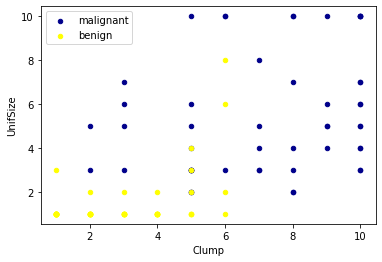

In [34]:
ax = cell_df[cell_df['Class'] == 4][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='DarkBlue', label='malignant');
cell_df[cell_df['Class'] == 2][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='Yellow', label='benign', ax=ax);
plt.show()

In [35]:
# for demo
d_dummy = cell_df[cell_df['Class'] == 4][0:10]
print(type(d_dummy))
d_dummy

<class 'pandas.core.frame.DataFrame'>


,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
5,1017122,8,10,10,8,7,10,9,7,1,4
12,1041801,5,3,3,3,2,3,4,4,1,4
14,1044572,8,7,5,10,7,9,5,5,4,4
15,1047630,7,4,6,4,6,1,4,3,1,4
18,1050670,10,7,7,6,4,10,4,1,2,4
20,1054590,7,3,2,10,5,10,5,4,4,4
21,1054593,10,5,5,3,6,7,7,10,1,4
23,1057013,8,4,5,1,2,?,7,3,1,4
25,1065726,5,2,3,4,2,7,3,6,1,4
32,1072179,10,7,7,3,8,5,7,4,3,4


## Data pre-processing and selection

Lets first look at columns data types:

In [25]:
cell_df.dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

It looks like the __BareNuc__ column includes some values that are not numerical. We can drop those rows:

In [36]:
# For demo / testing only
pd.to_numeric(cell_df['BareNuc'], errors='coerce').notnull()

0      True
1      True
2      True
3      True
4      True
       ... 
694    True
695    True
696    True
697    True
698    True
Name: BareNuc, Length: 699, dtype: bool

In [37]:
cell_df = cell_df[pd.to_numeric(cell_df['BareNuc'], errors='coerce').notnull()] # the expression inside the square bracket generates a mask array.
cell_df['BareNuc'] = cell_df['BareNuc'].astype('int')
cell_df.dtypes

ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int32
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

In [38]:
feature_df = cell_df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]
X = np.asarray(feature_df)
X[0:5]

array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
       [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
       [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
       [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
       [ 4,  1,  1,  3,  2,  1,  3,  1,  1]], dtype=int64)

We want the model to predict the value of Class (that is, benign (=2) or malignant (=4)). As this field can have one of only two possible values, we need to change its measurement level to reflect this.

In [39]:
# For testing only 
demo = np.asanyarray(feature_df)
demo[0:5]

array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
       [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
       [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
       [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
       [ 4,  1,  1,  3,  2,  1,  3,  1,  1]], dtype=int64)

In [40]:
cell_df['Class'] = cell_df['Class'].astype('int')
y = np.asarray(cell_df['Class'])
print(y [0:5])
print(cell_df.dtypes)

[2 2 2 2 2]
ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int32
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int32
dtype: object


## Train/Test dataset

Okay, we split our dataset into train and test set:

In [41]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (546, 9) (546,)
Test set: (137, 9) (137,)


<h2 id="modeling">Modeling (SVM with Scikit-learn)</h2>

The SVM algorithm offers a choice of kernel functions for performing its processing. Basically, mapping data into a higher dimensional space is called kernelling. The mathematical function used for the transformation is known as the kernel function, and can be of different types, such as:

    1.Linear
    2.Polynomial
    3.Radial basis function (RBF)
    4.Sigmoid
Each of these functions has its characteristics, its pros and cons, and its equation, but as there's no easy way of knowing which function performs best with any given dataset, we usually choose different functions in turn and compare the results. Let's just use the default, RBF (Radial Basis Function) for this lab.

In [42]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 

SVC()

After being fitted, the model can then be used to predict new values:

In [43]:
yhat = clf.predict(X_test)
yhat [0:5]

array([2, 4, 2, 4, 2])

<h2 id="evaluation">Evaluation</h2>

In [44]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [45]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           2       1.00      0.94      0.97        90
           4       0.90      1.00      0.95        47

    accuracy                           0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg       0.97      0.96      0.96       137

Confusion matrix, without normalization
[[85  5]
 [ 0 47]]


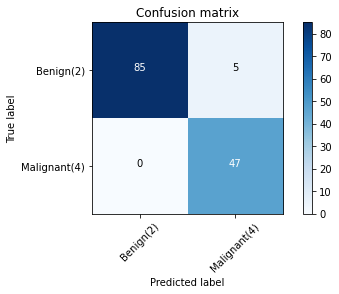

In [46]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[2,4])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Benign(2)','Malignant(4)'],normalize= False,  title='Confusion matrix')

You can also easily use the __f1_score__ from sklearn library:

In [47]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted') 

0.9639038982104676

Lets try jaccard index for accuracy:

In [48]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)

C:\Users\XXXXX\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


0.9635036496350365

<h2 id="practice">Practice</h2>
Can you rebuild the model, but this time with a __linear__ kernel? You can use __kernel='linear'__ option, when you define the svm. How the accuracy changes with the new kernel function?

In [50]:
# write your code here
from sklearn import svm
# our linear SVM model
model = svm.SVC(kernel='linear')
model.fit(X_train, y_train) 
# Lets test our model
model_prediction = model.predict(X_test)
# Accuracy evaluation
print("f1_score: ", f1_score(y_test, model_prediction , average='weighted'))
print("jaccard_similarity_score: ", jaccard_similarity_score(y_test, model_prediction))

f1_score:  0.9639038982104676
jaccard_similarity_score:  0.9635036496350365


C:\Users\XXXXX\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


#### We see from above that our accuracy scores remain exactly the same, which indicates that for this data set switching the kernel from <b>radial basis</b> function to <b>linear</b> doesnot make any differnce in terms of accuracy 